In [1]:
import mcnpy
from mcnpy.ace.analysis import get_cross_section_dataframe
import os
from mcnpy.utils import configure_ace_debug_logging

# Configure debug logging
#configure_ace_debug_logging(enable=True)  # Set to False to disable debug output

In [2]:
acefile = 'files/260560_80.06c'

In [3]:
ace = mcnpy.read_ace(acefile)

In [4]:
ace.angular_distributions

                              Angular Distribution Container                              

This container holds angular distributions read directly from the ACE file.
Each distribution preserves the original data structure as found in the ACE format.

Angular distributions describe the probability of scattering as a function of the
cosine of the scattering angle (μ), which ranges from -1 (backward scattering) to
+1 (forward scattering).

Available Angular Distribution Data:
------------------------------------------------------------------------------------------
Distribution Type                        Status                                         
------------------------------------------------------------------------------------------
Elastic Scattering (MT=2)                Available (TABULATED)                          
Neutron Reactions                        Available (4 reactions)                        
  KALBACH_MANN                           3 reactions                   

In [5]:
ace.angular_distributions.elastic   

                       Tabulated Angular Distribution for MT=2                       

This object contains tabulated angular distribution data for reaction MT=2.

DISTRIBUTION STRUCTURE:
The tabulated format stores the angular distribution as explicit probability
density functions (PDFs) and cumulative distribution functions (CDFs) for a set of
incident energy points. The data is organized as follows:

1. Energy Grid: A set of incident neutron energies (E₁, E₂, ..., Eₙ)
2. For each energy point, the distribution includes:
   a. Interpolation flag (1=histogram, 2=linear-linear)
   b. Set of cosine values (μ) ranging from -1 to 1
   c. PDF values (probability density function) for each cosine
   d. CDF values (cumulative distribution function) for each cosine

INTERPOLATION METHODS:
- Between incident energy points: Linear interpolation of PDF values
- Within a cosine grid (μ values):
  * Histogram (flag=1): PDF value is constant within each cosine bin
  * Linear-linear (flag=2): Linear

In [35]:
print(ace.angular_distributions.elastic.pdf[3000])
print(ace.angular_distributions.elastic.cosine_grid[3000])

[0.4086579, 0.409854, 0.4154928, 0.4133772, 0.40755, 0.3946488, 0.3790499, 0.3506951, 0.3332496, 0.2479604, 0.2273988, 0.2088846, 0.194472, 0.1856026, 0.1794263, 0.1751726, 0.1730205, 0.1730389, 0.1752874, 0.1798189, 0.1866231, 0.195745, 0.207113, 0.2211064, 0.2368842, 0.2597859, 0.2860302, 0.322042, 0.362855, 0.4086101, 0.4596413, 0.5152622, 0.5802228, 0.650388, 0.7318531, 0.8191468, 0.9147224, 1.016511, 1.062492, 1.159557, 1.268478, 1.42509, 1.533899, 1.690459, 2.067343]
[-1.0, -0.937, -0.827, -0.765, -0.718, -0.659, -0.609, -0.538, -0.5, -0.327, -0.281, -0.234, -0.19, -0.156, -0.125, -0.0937, -0.0625, -0.0312, 0.0, 0.0313, 0.0625, 0.0938, 0.125, 0.157, 0.188, 0.227, 0.266, 0.313, 0.36, 0.407, 0.454, 0.5, 0.548, 0.594, 0.641, 0.685, 0.727, 0.766, 0.782, 0.813, 0.844, 0.883, 0.907, 0.938, 1.0]


(<Figure size 800x600 with 1 Axes>,
 <Axes: title={'center': 'Angular Distribution for MT=2 at 1.624 MeV'}, xlabel='Cosine (μ)', ylabel='Probability Density'>)

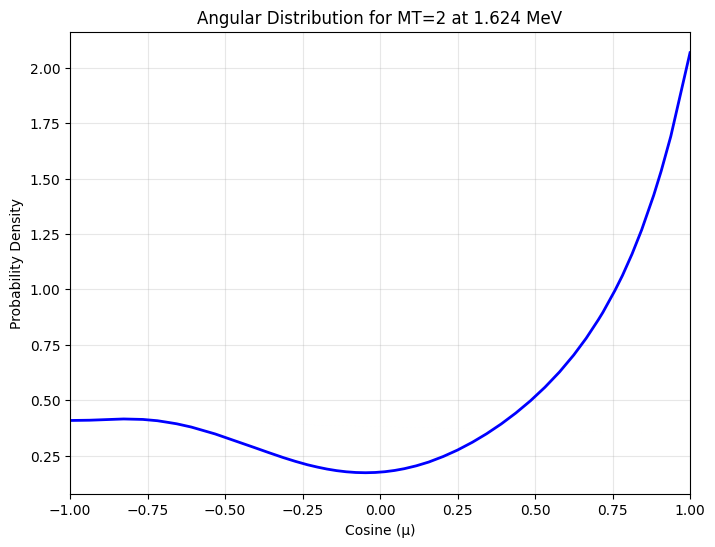

In [36]:
ene = ace.angular_distributions.elastic.energies
ace.angular_distributions.elastic.plot(energy=ene[3000])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial.legendre import Legendre

In [51]:
num = 100

In [52]:
pdf = np.array(ace.angular_distributions.elastic.pdf[num])
cosines = np.array(ace.angular_distributions.elastic.cosine_grid[num])

In [73]:
L_max = 4

/tmp/ipykernel_20970/3044299134.py:8: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  a_ell = np.trapz(pdf * P_ell, cosines)


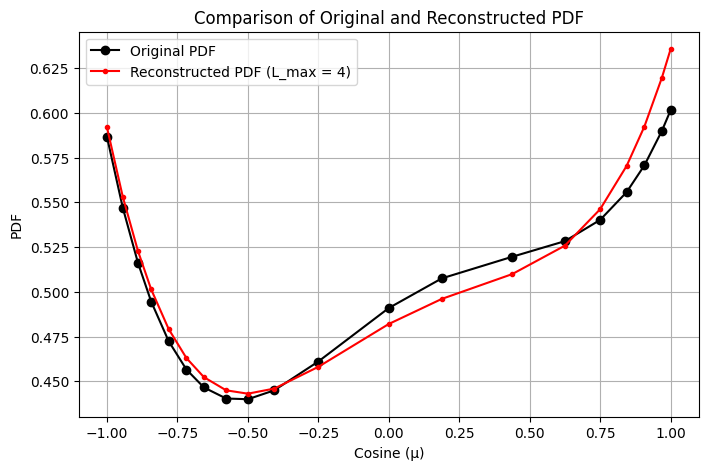

Legendre coefficients (up to order L_max = 10):
a_0 = 1.000000
a_1 = 0.031999
a_2 = 0.027723
a_3 = -0.007478
a_4 = 0.009865


In [74]:
# Function to compute Legendre coefficients from the PDF
def compute_legendre_coeffs(pdf, cosines, L_max):
    coeffs = []
    for ell in range(L_max+1):
        # Evaluate the Legendre polynomial P_ell at all cosine values.
        P_ell = Legendre.basis(ell)(cosines)
        # Compute the integral using the trapezoidal rule.
        a_ell = np.trapz(pdf * P_ell, cosines)
        coeffs.append(a_ell)
    return np.array(coeffs)

# Compute the Legendre coefficients
a_coeffs = compute_legendre_coeffs(pdf, cosines, L_max)

# Function to reconstruct the PDF from Legendre coefficients
def reconstruct_pdf(a_coeffs, cosines):
    f_rec = np.zeros_like(cosines)
    L_max = len(a_coeffs)-1
    for ell in range(L_max+1):
        P_ell = Legendre.basis(ell)(cosines)
        f_rec += 0.5 * (2*ell + 1) * a_coeffs[ell] * P_ell
    return f_rec

# Reconstruct the PDF from the Legendre coefficients
pdf_reconstructed = reconstruct_pdf(a_coeffs, cosines)

# Plot the original PDF and the reconstructed PDF
plt.figure(figsize=(8, 5))
plt.plot(cosines, pdf, 'ko-', label='Original PDF')
plt.plot(cosines, pdf_reconstructed, 'r.-', label=f'Reconstructed PDF (L_max = {L_max})')
plt.xlabel('Cosine (μ)')
plt.ylabel('PDF')
plt.title('Comparison of Original and Reconstructed PDF')
plt.legend()
plt.grid(True)
plt.show()

# For further analysis, let's print the computed Legendre coefficients.
print("Legendre coefficients (up to order L_max = 10):")
for ell, coeff in enumerate(a_coeffs):
    print(f"a_{ell} = {coeff:.6f}")


/tmp/ipykernel_20970/2872562681.py:14: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  pdf = pdf / np.trapz(pdf, mu)


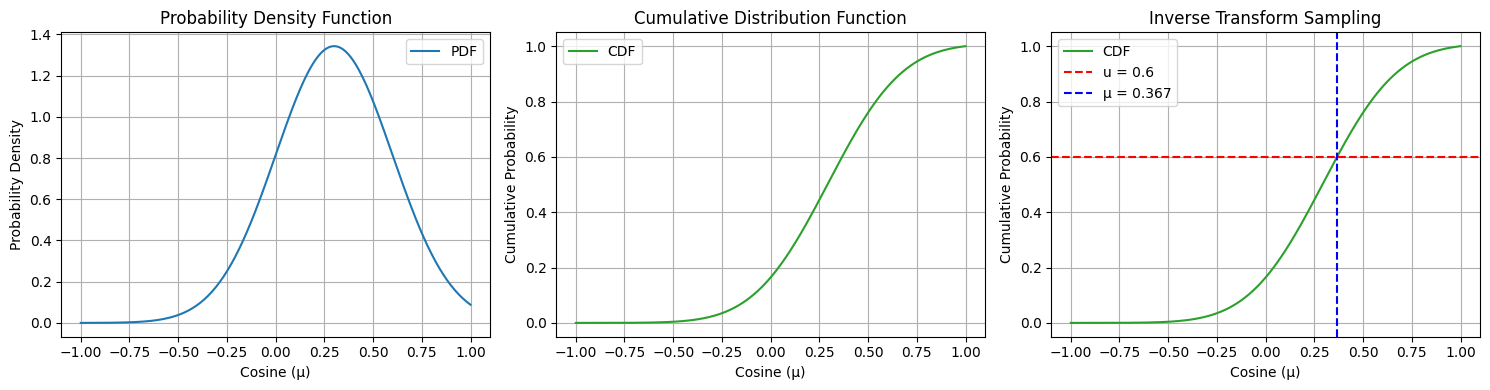

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Define a cosine grid (more points for smooth curves in the demonstration)
mu = np.linspace(-1, 1, 200)

# Construct a PDF. For example, use a Gaussian-like function in cosine space 
# to simulate an anisotropic scattering distribution.
mu_center = 0.3  # center of the peak (can be adjusted to simulate forward/backward bias)
sigma = 0.3
pdf = np.exp(-((mu - mu_center)**2) / (2 * sigma**2))

# Normalize the PDF so the integral over [-1, 1] is 1
pdf = pdf / np.trapz(pdf, mu)

# Compute the CDF by a cumulative numerical integration (using a cumulative sum)
cdf = np.cumsum(pdf * (mu[1] - mu[0]))  # multiply by bin width
cdf = cdf / cdf[-1]  # ensure it ends at exactly 1

# Plot the PDF and CDF side by side, plus a demonstration of sampling.
plt.figure(figsize=(15, 4))

# Plot 1: PDF
plt.subplot(1, 3, 1)
plt.plot(mu, pdf, label='PDF', color='C0')
plt.title('Probability Density Function')
plt.xlabel('Cosine (μ)')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)

# Plot 2: CDF
plt.subplot(1, 3, 2)
plt.plot(mu, cdf, label='CDF', color='C2')
plt.title('Cumulative Distribution Function')
plt.xlabel('Cosine (μ)')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.grid(True)

# Plot 3: Inverse Transform Sampling Demonstration
# Choose an example random value u (like what the transport code would generate)
u = 0.6  # in a real case, u would be randomly drawn from Uniform[0,1]
# Find the cosine value corresponding to u using interpolation of the CDF
mu_sample = np.interp(u, cdf, mu)

plt.subplot(1, 3, 3)
plt.plot(mu, cdf, label='CDF', color='C2')
# Mark the horizontal line at u and the vertical line at the sampled cosine
plt.axhline(y=u, color='red', linestyle='--', label=f'u = {u}')
plt.axvline(x=mu_sample, color='blue', linestyle='--', label=f'μ = {mu_sample:.3f}')
plt.title('Inverse Transform Sampling')
plt.xlabel('Cosine (μ)')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


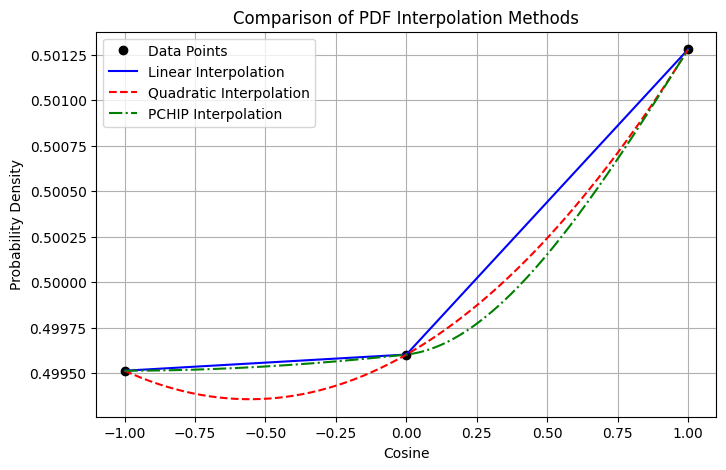

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, PchipInterpolator

# Given data points
cosine = np.array([-1.0, 0.0, 1.0])
pdf = np.array([0.4995137, 0.4996026, 0.5012811])
cdf = np.array([0.0, 0.4995582, 1.0])

# Create a dense set of points for plotting
xnew = np.linspace(-1, 1, 200)

# Linear interpolation: directly connects the data points.
linear_interp = interp1d(cosine, pdf, kind='linear')
pdf_linear = linear_interp(xnew)

# Quadratic interpolation: now works with 3 points.
quadratic_interp = interp1d(cosine, pdf, kind='quadratic')
pdf_quadratic = quadratic_interp(xnew)

# Alternatively, using a monotonic interpolator like PCHIP
pchip_interp = PchipInterpolator(cosine, pdf)
pdf_pchip = pchip_interp(xnew)

# Plotting the results
plt.figure(figsize=(8, 5))
plt.plot(cosine, pdf, 'ko', label='Data Points')
plt.plot(xnew, pdf_linear, 'b-', label='Linear Interpolation')
plt.plot(xnew, pdf_quadratic, 'r--', label='Quadratic Interpolation')
plt.plot(xnew, pdf_pchip, 'g-.', label='PCHIP Interpolation')
plt.xlabel('Cosine')
plt.ylabel('Probability Density')
plt.title('Comparison of PDF Interpolation Methods')
plt.legend()
plt.grid(True)
plt.show()


In [36]:
# Get the list of original energy points
energy_points = elastic_dist.energies

# Find the closest energy point to your target energy
target_energy = 1  # MeV
closest_idx = min(range(len(energy_points)), key=lambda i: abs(energy_points[i] - target_energy))
closest_energy = energy_points[closest_idx]

print(f"Closest energy point in the file: {closest_energy} MeV")

# Get data for this exact energy point (no interpolation)
df = elastic_dist.to_dataframe(energy=closest_energy, interpolate=False)
df

Closest energy point in the file: 1.0 MeV


,energy,cosine,pdf,cdf
0,1.0,-1.0000,0.851466,0.000000
1,1.0,-0.9760,0.808314,0.019745
2,1.0,-0.9520,0.771001,0.038674
3,1.0,-0.9290,0.740367,0.056104
4,1.0,-0.9060,0.714097,0.072935
5,1.0,-0.8760,0.687532,0.093840
6,1.0,-0.8430,0.663859,0.116044
7,1.0,-0.8120,0.644864,0.136406
8,1.0,-0.7730,0.626523,0.161078
9,1.0,-0.7180,0.603946,0.194277


In [5]:
ace.unresolved_resonance

                       Unresolved Resonance Probability Tables                       

No unresolved resonance probability tables available

In [6]:
acefile1 = 'files/922350_71.02c'

In [7]:
ace1 = mcnpy.read_ace(acefile1)

In [ ]:
ace1.unresolved_resonance

[XssEntry(Index=745964, Value=0.002250001),
 XssEntry(Index=745965, Value=0.0025),
 XssEntry(Index=745966, Value=0.0035),
 XssEntry(Index=745967, Value=0.0045),
 XssEntry(Index=745968, Value=0.0055),
 XssEntry(Index=745969, Value=0.0065),
 XssEntry(Index=745970, Value=0.0075),
 XssEntry(Index=745971, Value=0.0085),
 XssEntry(Index=745972, Value=0.0095),
 XssEntry(Index=745973, Value=0.0131),
 XssEntry(Index=745974, Value=0.015),
 XssEntry(Index=745975, Value=0.02),
 XssEntry(Index=745976, Value=0.024),
 XssEntry(Index=745977, Value=0.02499999)]

In [ ]:
#JXS(32)
3302476 + 10 *(1-1) + 8

3302484

In [ ]:
# JED de DLWH
3317561 + 96 - 1

3317656

In [ ]:
ace.energy_distributions.get_neutron_distribution(5)[0].distributions


[]

In [ ]:
dist = ang.incident_neutron[16]
dist

                      Kalbach-Mann Angular Distribution Details                      

This object represents an angular distribution using the Kalbach-Mann formalism.
The Kalbach-Mann model correlates energy and angle distributions, with parameters
R (precompound fraction) and A (angular slope) that vary with outgoing energy.

Data Structure Overview:
- In the ACE file, a LOCB value of -1 indicates a Kalbach-Mann distribution
- The actual angular distribution parameters (R and A) are stored in the
  energy distribution section as a Law=44 distribution
- This object stores reference indices to locate the Law=44 data when needed

IMPORTANT: This distribution REQUIRES Law=44 data from the energy distribution
section (DLW/DLWH blocks). The ACE object must be provided to all methods that
calculate or sample angular distributions. Without this data, methods will raise
a Law44DataError exception.

Data Information:
-----------------------------------------------------------------------------

In [ ]:
ace.energy_distributions

                            Energy Distribution Container                            

This container holds energy distributions for secondary particles produced in nuclear reactions.
Distributions are organized by particle type (neutron, photon, other) and reaction (MT number).
Each reaction can have multiple distribution laws that apply in different energy ranges.

Available Energy Distribution Data:
-------------------------------------------------------------------------------------
Distribution Type                        Status                                    
-------------------------------------------------------------------------------------
Incident Neutron Distributions           Available (42 MT numbers)                 
Photon Production Distributions          Available (532 MT numbers)                
Particle Production Distributions        Available (5 particle types)              
Delayed Neutron Distributions            None (0 groups)                           
En

In [ ]:
ace.energy_distributions.print_distribution_info()

                                Energy Distribution Type Information                                

Incident Neutron Energy Distributions
----------------------------------------------------------------------------------------------------
MT       Law      Distribution Type              Access Method                                     
----------------------------------------------------------------------------------------------------
5        61       TabulatedAngleEnergyDistribution .get_neutron_distribution(5)                      
16       61       TabulatedAngleEnergyDistribution .get_neutron_distribution(16)                     
51       3        LevelScattering                .get_neutron_distribution(51)                     
52       3        LevelScattering                .get_neutron_distribution(52)                     
53       3        LevelScattering                .get_neutron_distribution(53)                     
54       3        LevelScattering                .get_

In [ ]:
ace.energy_distributions.get_neutron_distribution(5)[0]

                  Tabulated Angle-Energy Distribution (Law 61)                  
This distribution provides correlated angle-energy distributions using tabular
angular distributions. It corresponds to Law 61 in the ACE format.
Similar to LAW=44 but uses tabular angular distributions instead of Kalbach-Mann formalism.

Basic Properties:
--------------------------------------------------------------------------------
Distribution Law                         61 (Tabulated Angle-Energy)          
Number of Interpolation Regions          2                                    
Number of Incident Energies              0                                    
Number of Energy Distributions           0                                    
Number of Angular Tables                 0                                    
--------------------------------------------------------------------------------

Available Methods:
--------------------------------------------------------------------------------
Meth

In [ ]:
ace.energy_distributions.get_neutron_distribution(5)[0].applicability_energies

[XssEntry(Index=2067964, Value=1e-11),
 XssEntry(Index=2067965, Value=6.0),
 XssEntry(Index=2067966, Value=10.5),
 XssEntry(Index=2067967, Value=11.0),
 XssEntry(Index=2067968, Value=11.25),
 XssEntry(Index=2067969, Value=11.5),
 XssEntry(Index=2067970, Value=12.0),
 XssEntry(Index=2067971, Value=12.5),
 XssEntry(Index=2067972, Value=13.0),
 XssEntry(Index=2067973, Value=13.5),
 XssEntry(Index=2067974, Value=14.0),
 XssEntry(Index=2067975, Value=14.5),
 XssEntry(Index=2067976, Value=15.0),
 XssEntry(Index=2067977, Value=16.0),
 XssEntry(Index=2067978, Value=16.5),
 XssEntry(Index=2067979, Value=18.0),
 XssEntry(Index=2067980, Value=19.0),
 XssEntry(Index=2067981, Value=20.0),
 XssEntry(Index=2067982, Value=22.0),
 XssEntry(Index=2067983, Value=24.0),
 XssEntry(Index=2067984, Value=25.7),
 XssEntry(Index=2067985, Value=28.0),
 XssEntry(Index=2067986, Value=30.0),
 XssEntry(Index=2067987, Value=32.0),
 XssEntry(Index=2067988, Value=34.0),
 XssEntry(Index=2067989, Value=36.0),
 XssEntry(I

In [ ]:
ang.incident_neutron[51].to_dataframe(energy=14)

,cosine,probability
0,-1.000000,0.099977
1,-0.979798,0.219170
2,-0.959596,0.294011
3,-0.939394,0.335204
4,-0.919192,0.350943
...,...,...
95,0.919192,1.159403
96,0.939394,0.984290
97,0.959596,0.777105
98,0.979798,0.550318


In [ ]:
acefile_og = 'files/260560_80.06c_0002'
acefile_pert = 'files/260560_80.06c_0001'

In [ ]:
ace_og = mcnpy.read_ace(acefile_og)
ace_pert = mcnpy.read_ace(acefile_pert)

KeyboardInterrupt: 

In [ ]:
df = get_cross_section_dataframe([ace_og, ace_pert], 51)
df

,Energy,26056,26056_1
0,1.000000e-11,0.000000,0.000000
1,1.031250e-11,0.000000,0.000000
2,1.062500e-11,0.000000,0.000000
3,1.093750e-11,0.000000,0.000000
4,1.125000e-11,0.000000,0.000000
...,...,...,...
41041,1.250000e+02,0.005195,0.005195
41042,1.300000e+02,0.004796,0.004796
41043,1.400000e+02,0.004115,0.004115
41044,1.499999e+02,0.003563,0.003563


Are the columns exactly the same? False
Maximum absolute difference: 0.24363707434000004


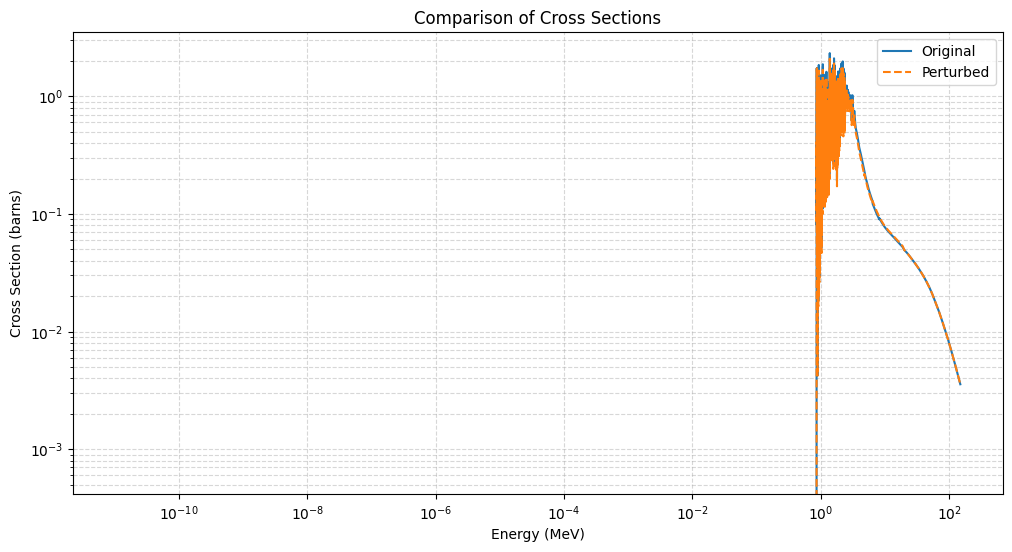

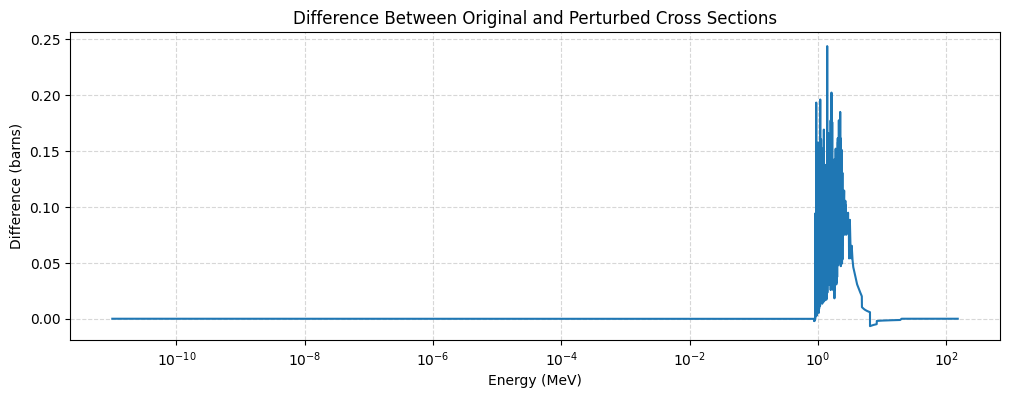

In [ ]:
import numpy as np

import matplotlib.pyplot as plt

# Check if both columns are exactly the same
exact_match = (df[26056] == df['26056_1']).all()
print(f"Are the columns exactly the same? {exact_match}")

# Calculate the absolute difference between columns
diff = df[26056] - df['26056_1']
max_diff = np.abs(diff).max()
print(f"Maximum absolute difference: {max_diff}")

# Plot both cross sections
plt.figure(figsize=(12, 6))
plt.plot(df['Energy'], df[26056], label='Original')
plt.plot(df['Energy'], df['26056_1'], label='Perturbed', linestyle='--')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Energy (MeV)')
plt.ylabel('Cross Section (barns)')
plt.title('Comparison of Cross Sections')
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.5)

# Plot the difference
if not exact_match:
    plt.figure(figsize=(12, 4))
    plt.plot(df['Energy'], diff)
    plt.xscale('log')
    plt.xlabel('Energy (MeV)')
    plt.ylabel('Difference (barns)')
    plt.title('Difference Between Original and Perturbed Cross Sections')
    plt.grid(True, which='both', linestyle='--', alpha=0.5)

In [ ]:
.

SyntaxError: invalid syntax (1933637684.py, line 1)

In [ ]:
# Define all ACE files to test
acefile = 'files/10010_71.02c'
acefile_U235 = 'files/922350_71.02c'
acefile1 = 'files/FE56.293600c'
acefile2 = 'files/260560_80.02c'

# Print files to verify they exist
for file_path in [acefile, acefile_U235, acefile1, acefile2]:
    print(f"File {file_path} exists: {os.path.exists(file_path)}")

File files/10010_71.02c exists: True
File files/922350_71.02c exists: True
File files/FE56.293600c exists: True
File files/260560_80.02c exists: True


In [ ]:
ace_U235 = mcnpy.read_ace(acefile_U235)

In [ ]:
ace_U235.unresolved_resonance

Unresolved Resonance Probability Tables
Number of energy points: 14
Table length: 20
Interpolation: linear-linear
Inelastic cross section: special MT=4
Other absorption cross section: zero in the unresolved range
Table values represent factors to multiply smooth cross sections
Energy range: 2.250001e-03 to 2.499999e-02 MeV
Total cross section range: 6.280051e-01 to 1.891055e+00 (factors)

In [ ]:
print(ace_U235.mt_numbers)

[1, 2, 4, 16, 17, 18, 37, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 101, 102, 444]


In [ ]:
ace_U235.cross_section.reaction.keys()

dict_keys([1, 2, 101, 16, 17, 18, 37, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 102, 444, 4])

In [ ]:
print(ace_U235.cross_section.mt_numbers)

[1, 2, 4, 16, 17, 18, 37, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 101, 102, 444]


In [ ]:
ace_U235.cross_section.reaction[4].to_dataframe()

,Energy,Cross Section
0,0.00225,0.000000e+00
1,0.00225,1.204971e-07
2,0.00230,1.251350e-07
3,0.00240,1.342625e-07
4,0.00250,1.433900e-07
...,...,...
425,18.00000,4.111469e-01
426,18.50000,3.994417e-01
427,19.00000,3.882021e-01
428,19.50000,3.764036e-01


In [ ]:
ace_U235.cross_section.to_dataframe()

,Energy,MT=1,MT=2,MT=4,MT=16,MT=17,MT=18,MT=37,MT=51,MT=52,...,MT=85,MT=86,MT=87,MT=88,MT=89,MT=90,MT=91,MT=101,MT=102,MT=444
0,1.000000e-11,37407.199500,58.331490,0.000000,0.000000,0.000000,31390.430000,0.000000e+00,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5958.438000,5958.438000,220.971000
1,1.031250e-11,36836.060100,57.493120,0.000000,0.000000,0.000000,30911.110000,0.000000e+00,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5867.457000,5867.457000,217.596900
2,1.062500e-11,36290.312800,56.692750,0.000000,0.000000,0.000000,30453.100000,0.000000e+00,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5780.520000,5780.520000,214.372700
3,1.093750e-11,35768.122700,55.927650,0.000000,0.000000,0.000000,30014.860000,0.000000e+00,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5697.335000,5697.335000,211.287800
4,1.125000e-11,35267.846300,55.195330,0.000000,0.000000,0.000000,29595.010000,0.000000e+00,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5617.641000,5617.641000,208.332300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76520,1.800000e+01,6.124479,3.134972,0.411147,0.211427,0.308173,2.058403,3.810030e-07,0.0,0.0,...,0.003198,0.001200,0.001310,0.001362,0.001021,0.001134,0.123749,0.000357,0.000357,0.219410
76521,1.850000e+01,6.147738,3.170238,0.399442,0.193505,0.340188,2.043946,8.441785e-05,0.0,0.0,...,0.003089,0.001158,0.001265,0.001315,0.000985,0.001095,0.119950,0.000335,0.000335,0.222942
76522,1.900000e+01,6.159560,3.190453,0.388202,0.178435,0.370183,2.031731,2.387410e-04,0.0,0.0,...,0.002983,0.001119,0.001222,0.001269,0.000951,0.001057,0.116218,0.000317,0.000317,0.226554
76523,1.950000e+01,6.165319,3.206368,0.376404,0.165893,0.393329,2.021675,1.348763e-03,0.0,0.0,...,0.002881,0.001081,0.001180,0.001226,0.000919,0.001021,0.111520,0.000302,0.000302,0.229946


In [ ]:
# Filter df to show values in the specified energy range
energy_range = df[(df['Energy'] >= 2.249703e-3) & (df['Energy'] <= 3e-3)]
display(energy_range)

# Optional: Show how many rows are in this range
print(f"Number of points in this energy range: {len(energy_range)}")

NameError: name 'df' is not defined

In [ ]:
loc = 459766
print((loc)/4+13-0.25)

114954.25


In [1]:
import sandy
sandy.get_njoy()

'/home/MONLEON-JUAN/NJOY2016/NJOY2016-main/build/njoy'